# PCA Analysis
## Last Updated: May 23, 2020

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import pysal
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale  
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import model_selection

from scipy.stats import boxcox
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import gmean

In [2]:
# For reproducibility
import random
r_state = 42
random.seed(r_state) 
np.random.seed(r_state)

In [3]:
cwd = os.getcwd()
ses = os.path.join(cwd, 'data', 'scores')
geo_18 = os.path.join(cwd, 'data', 'shapefiles', 'tl_2018_17_tract')
geo_13 = os.path.join(cwd, 'data', 'shapefiles', 'tl_2013_17_tract')
neighs = os.path.join(cwd, 'data', 'shapefiles', 'chi_neighborhoods')

### STEP 1: Data Processing
Tasks: Loading data, minor cleaning, dropping unpopulated census tracts, merging data sets

In [4]:
# SELECT OPTION TO RESTRICT DATA TO CENSUS TRACTS DETERMINED TO BE "WITHIN" CHICAGO

city_limits = False # Options: True [restrict to city limits] or False [do not restrict to city limits]

In [5]:
# Import data with socioeconomic variables
DTYPE = {
    'Median Annual Household Income': np.float64,
    'Median Monthly Housing Costs': np.float64,
    'Median Value for Owner-Occupied Housing Units': np.float64,
    'Percent White Collar': np.float64,
    'Percent College Graduate': np.float64,
    'geo11': str
}

# Rename columns to something easier to work with

COL_NAMES = {
    'Median Annual Household Income': 'median_hh_inc',
    'Median Monthly Housing Costs': 'median_mhc',
    'Median Value for Owner-Occupied Housing Units': 'median_housing_value',
    'Percent White Collar': 'per_white_collar',
    'Percent College Graduate': 'per_grads'
}

# 2013 ACS data

acs_13 = pd.read_csv(ses + '/acs5_2013_chicago_socioeconomic_vars.csv', dtype=DTYPE)
acs_13 = acs_13.sort_values(by='geo11') # Sorting the index makes it easier to combine data sets later on in the analysis
acs_13 = acs_13.set_index('geo11')
acs_13 = acs_13.drop(['GEO_ID'], axis=1)
# These census tracts are unpopulated, so I'm dropping them:
# https://censusreporter.org/profiles/14000US17031381700-census-tract-3817-cook-il/
# https://censusreporter.org/profiles/14000US17031980000-census-tract-9800-cook-il/
# https://censusreporter.org/profiles/14000US17031980100-census-tract-9801-cook-il/
# https://censusreporter.org/profiles/14000US17031990000-census-tract-9900-cook-il/
acs_13 = acs_13.drop(['17031381700', '17031980000', '17031980100', '17031990000'])
acs_13 = acs_13.rename(columns=COL_NAMES)

# 2018 ACS data (same caveats as for 2013 data)

acs_18 = pd.read_csv(ses + '/acs5_2018_chicago_socioeconomic_vars.csv', dtype=DTYPE)
acs_18 = acs_18.sort_values(by='geo11')
acs_18 = acs_18.set_index('geo11')
acs_18 = acs_18.drop(['GEO_ID'], axis=1)
acs_18 = acs_18.drop(['17031381700', '17031980000', '17031980100', '17031990000'])
acs_18 = acs_18.rename(columns=COL_NAMES)

# Check that acs_18 and acs_13 have the same index
print()
print('Indexes the same? ', all(acs_13.index == acs_18.index))

# Illinois Shape Files (used to compute geometric mean to fill NAs)

il_shape_18 = gpd.read_file(geo_18 + '/tl_2018_17_tract.shp').rename(columns={'GEOID': 'geo11'})
il_shape_18 = il_shape_18.set_index('geo11')
il_shape_13 = gpd.read_file(geo_13 + '/tl_2013_17_tract.shp').rename(columns={'GEOID': 'geo11'})
il_shape_13 = il_shape_13.set_index('geo11')

# Boundaries for Census Tracts in Chicago from the Chicago Data Portal (based on 2010 Census boundaries)

chi_tracts = gpd.read_file(neighs + '/Boundaries - Census Tracts - 2010.geojson')
chi_tracts = chi_tracts.drop([x for x in chi_tracts.columns if 'geoid' not in x and 'comm' not in x], axis=1)
chi_tracts = chi_tracts.rename(columns={'geoid10': 'geo11'}).set_index('geo11')

# Boundaries for Community Areas in Chicago from the Chicago Data Portal (current)

commarea = gpd.read_file(neighs + '/Boundaries - Community Areas (current).geojson').rename(columns={'area_num_1': 'commarea'})


Indexes the same?  True


In [6]:
# Here, we merge the ACS data with the chi_tracts data to filter
# out census tracts that are not within the city limits

if city_limits:
    acs_18 = pd.merge(acs_18, chi_tracts, how='inner', left_index=True, right_index=True)
    acs_13 = pd.merge(acs_13, chi_tracts, how='inner', left_index=True, right_index=True)

In [7]:
acs_13.head(1)

,median_hh_inc,median_mhc,median_housing_value,per_white_collar,per_grads
geo11,,,,,
17031010100,32191.0,905.0,205300.0,0.389247,0.4169


In [8]:
acs_18.head(1)

,median_hh_inc,median_mhc,median_housing_value,per_white_collar,per_grads
geo11,,,,,
17031010100,37985.0,960.0,257400.0,0.476343,0.493519


In [9]:
il_shape_18.head(1)

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
geo11,,,,,,,,,,,,
17091011700,17,091,011700,117,Census Tract 117,G5020,S,2370100,102060,+41.1294653,-087.8735796,"POLYGON ((-87.88768 41.13594, -87.88764 41.136..."


In [10]:
il_shape_13.head(1)

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
geo11,,,,,,,,,,,,
17161022800,17,161,022800,228,Census Tract 228,G5020,S,2097335,0,+41.4990973,-090.5473216,"POLYGON ((-90.55724 41.49433, -90.55724 41.494..."


In [11]:
# Merge the ACS data with the IL shapefiles and convert to GeoDataFrame
merged_18 = gpd.GeoDataFrame(pd.merge(acs_18, il_shape_18, how='inner', left_index=True, right_index=True), crs=il_shape_18.crs)
merged_13 = gpd.GeoDataFrame(pd.merge(acs_13, il_shape_13, how='inner', left_index=True, right_index=True), crs=il_shape_13.crs)

In [12]:
merged_18.head(1)

,median_hh_inc,median_mhc,median_housing_value,per_white_collar,per_grads,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
geo11,,,,,,,,,,,,,,,,,
17031010100,37985.0,960.0,257400.0,0.476343,0.493519,17,031,010100,101,Census Tract 101,G5020,S,379751,0,+42.0212564,-087.6698316,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."


In [13]:
merged_13.head(1)

,median_hh_inc,median_mhc,median_housing_value,per_white_collar,per_grads,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
geo11,,,,,,,,,,,,,,,,,
17031010100,32191.0,905.0,205300.0,0.389247,0.4169,17,031,010100,101,Census Tract 101,G5020,S,381062,0,+42.0212617,-087.6698442,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."


In [14]:
print(merged_18.shape)
print(merged_13.shape)

(1315, 17)
(1315, 17)


#### Dealing with NAs
Tasks: Computing spatial weights, finding neighbors of tracts with missing values, using those neighbors' values to fill in missing values

In [15]:
# Compute the spatial contiguity weights, which are used to find the neighbors of tracts with missing data
# We use Queen neighbors, which is more inclusive of neighbors, because it requires only that polygons share a vertex
# Could use Rook neighbors if we want to be more restrictive
# Approach here is a modified version of the approached used in the London Gentfication paper

w18 = pysal.lib.weights.Queen.from_dataframe(merged_18.reset_index(), idVariable='geo11')
w13 = pysal.lib.weights.Queen.from_dataframe(merged_13.reset_index(), idVariable='geo11')

In [16]:
print("Summary Statistics from Spatial Weights Analysis, 2018")
print("\tMean neighbors: " + str(w18.mean_neighbors))
print("\tMax neighbors:  " + str(w18.max_neighbors))
print("\tMin neighbors:  " + str(w18.min_neighbors))
print("\tNo. Islands:     " + str(len(w18.islands)))

print("Summary Statistics from Spatial Weights Analysis, 2013")
print("\tMean neighbors: " + str(w13.mean_neighbors))
print("\tMax neighbors:  " + str(w13.max_neighbors))
print("\tMin neighbors:  " + str(w13.min_neighbors))
print("\tNo. Islands:     " + str(len(w13.islands)))

Summary Statistics from Spatial Weights Analysis, 2018
	Mean neighbors: 6.536882129277567
	Max neighbors:  18
	Min neighbors:  2
	No. Islands:     0
Summary Statistics from Spatial Weights Analysis, 2013
	Mean neighbors: 6.53384030418251
	Max neighbors:  18
	Min neighbors:  2
	No. Islands:     0


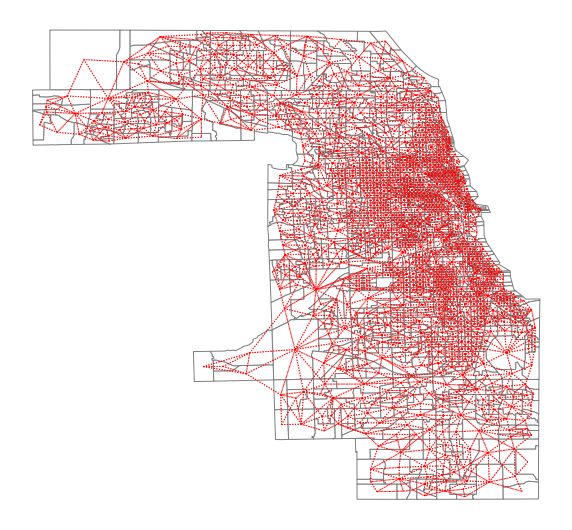

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = merged_18.plot(edgecolor='grey', facecolor='w', ax=ax)
f, ax = w18.plot(merged_18, ax=ax, edge_kws=dict(color='r', linestyle=':', linewidth=1), node_kws=dict(marker=''))
ax.set_axis_off()

In [18]:
# Find the columns in each dataset that contain missing values

print("2018...\n")
for col in acs_18.columns:
    print('\t' + col +':', acs_18[col].isna().sum())
print('2013...\n')
for col in acs_13.columns:
    print('\t' + col +':', acs_13[col].isna().sum())

2018...

	median_hh_inc: 0
	median_mhc: 0
	median_housing_value: 13
	per_white_collar: 0
	per_grads: 0
2013...

	median_hh_inc: 0
	median_mhc: 0
	median_housing_value: 7
	per_white_collar: 1
	per_grads: 0


In [19]:
def get_gmean_from_neighbors(w, df, tract, column):
    """
    Find geometric mean of a tracts neighbours' for a given column.
    """
    print("\t\tSearching for: " + ", ".join(w[tract]))
    print()
    neighbor_values = df.loc[w.neighbors[tract], column].values
    print("\t\tFound " + column + ": " + ", ".join(map(str, neighbor_values)))
    print()
    if 'white' not in column:
        return round(gmean(neighbor_values[np.logical_not(np.isnan(neighbor_values))]), -1)
    else:
        return gmean(neighbor_values[np.logical_not(np.isnan(neighbor_values))])

In [20]:
# Fill the missing values with the geometric mean of neighboring tracts

print('2018...\n')
cols_to_fill = ['median_housing_value']
for col in cols_to_fill:
    print('\tImputing missing values for ' + col + '\n')
    nan = merged_18[merged_18[col].isna()].index.values
    print(f'\tThere are {len(nan)} tracts with missing values for ' + col + '\n')
    for idx in nan:
        print(f'\tLooking for neighbors of tract {idx}\n')
        m = get_gmean_from_neighbors(w18, merged_18, idx, col)
        print(f'\tMean found: {m}\n')
        merged_18.loc[idx, col] = m

print()
print('2013...\n')
cols_to_fill = ['median_housing_value', 'per_white_collar']
for col in cols_to_fill:
    print('\tImputing missing values for ' + col + '\n')
    nan = merged_13[merged_13[col].isna()].index.values
    print(f'\tThere are {len(nan)} tracts with missing values for ' + col + '\n')
    for idx in nan:
        print(f'\tLooking for neighbors of tract {idx}\n')
        m = get_gmean_from_neighbors(w13, merged_13, idx, col)
        print(f'\tMean found: {m}\n')
        merged_13.loc[idx, col] = m

2018...

	Imputing missing values for median_housing_value

	There are 13 tracts with missing values for median_housing_value

	Looking for neighbors of tract 17031270500

		Searching for: 17031843000, 17031836800, 17031260100, 17031271400, 17031260900, 17031271500, 17031260800, 17031271300, 17031836900

		Found median_housing_value: 172500.0, 260500.0, 125000.0, 183800.0, 131300.0, 185800.0, 183200.0, 196300.0, 214800.0

	Mean found: 179610.0

	Looking for neighbors of tract 17031340600

		Searching for: 17031842000, 17031340500, 17031380500, 17031840000, 17031835500, 17031351500

		Found median_housing_value: 271300.0, 296400.0, nan, 342100.0, 124600.0, 275000.0

	Mean found: 248240.0

	Looking for neighbors of tract 17031350100

		Searching for: 17031839200, 17031839500, 17031351000, 17031841000

		Found median_housing_value: 143300.0, 299200.0, 356900.0, 317300.0

	Mean found: 263970.0

	Looking for neighbors of tract 17031350400

		Searching for: 17031842000, 17031340500, 17031839

### STEP 2: Transforming Variables
Tasks: Transform 'median_hh_inc', 'median_housing_value', and 'median_mhc' using different transformations

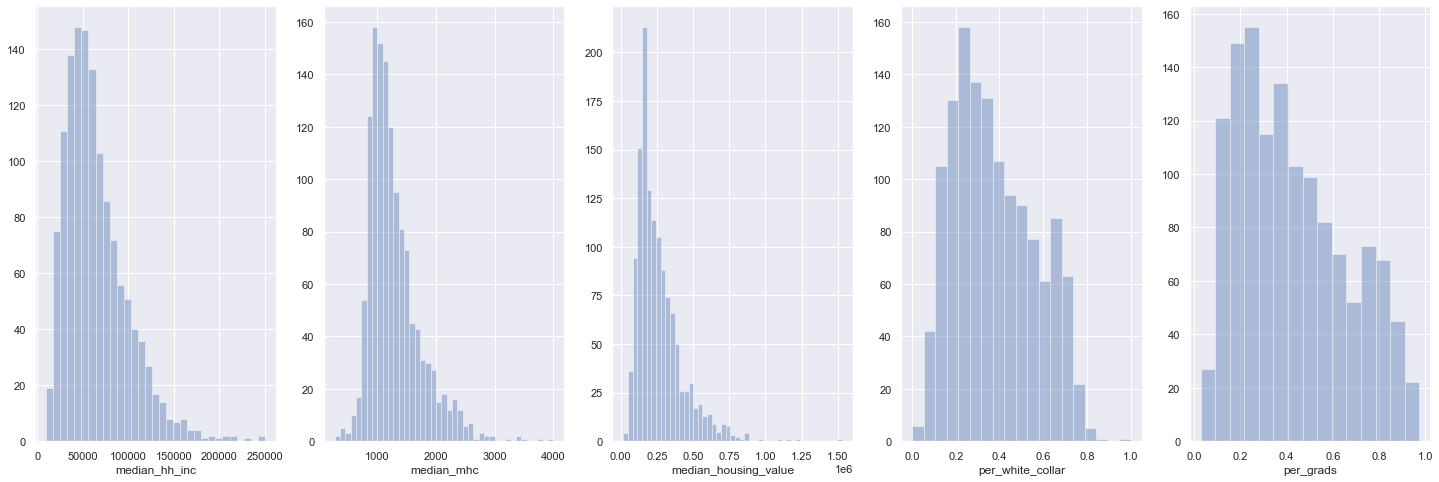

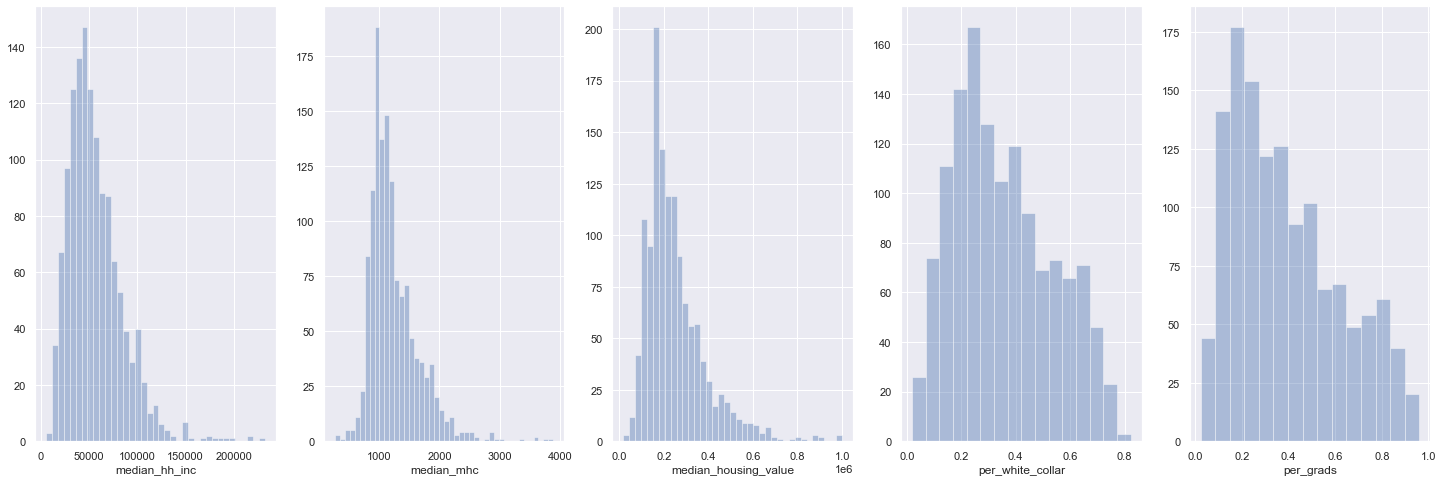

In [21]:
# Create some distribution plots to show the skewness of different variables
def show_distribution(df, variables, bins=None, figsize=(10, 10)):
    """
    Show the distribution of a variable in the data
    :param variable: (list) names of the variables to plot
    :param bins: (int) number of bins to use in plot
    :param figsize: (tuple of ints) figure dimensions
    """

    sns.set(style='darkgrid', palette='deep')
    fig, ax = plt.subplots(1, len(variables), figsize=figsize)
    ax_vars = zip(ax, variables)
    for axis, var in ax_vars:
        if bins:
            sns.distplot(df[var], bins=bins, ax=axis, kde=False)
        else:
            sns.distplot(df[var], ax=axis, kde=False)
    plt.show()

show_distribution(merged_18, acs_18.columns, figsize=(25, 8))
show_distribution(merged_13, acs_13.columns, figsize=(25, 8))

#### Analysis of Distributions

Notice how skewed the distributions for median income, housing costs, and housing value are compared to the distributions for percent white collar and percent college graduates. We will use a few transformations to see if we can tranform the skewed variables to better fit a normal distribution.

### Option 1: No Transform
Passing median_hh_inc, median_mhc, and median_housing_value into PCA 'as is.'

In [22]:
df_transformed_18 = pd.DataFrame({
    'median_hh_inc_18u' : merged_18['median_hh_inc'],
    'median_mhc_18u' : merged_18['median_mhc'],
    'median_housing_value_18u' : merged_18['median_housing_value']
}, index=merged_18.index)

df_transformed_13 = pd.DataFrame({
    'median_hh_inc_13u' : merged_13['median_hh_inc'],
    'median_mhc_13u' : merged_13['median_mhc'],
    'median_housing_value_13u' : merged_13['median_housing_value']
}, index=merged_13.index)

### Option 2: Box-Cox Transform

In this option with use Box-Cox transforms on these three variables so that they are pseudo-normal. Note that we need to use the same transform on both years so as to ensure that the results are comparable across 2013/2018. Since educational attainment and occupation remain skewed (albeit much less so) this will tend to highlight changes in 'human factor' issues and deemphasise financial changes.

In [23]:
# We want to use the same transform so that change is detectable
mhi13, lmd13a = boxcox(merged_13['median_hh_inc'])  #  Process 2013 data
print("2013 household income transform lambda: " + str(lmd13a))
mhi18 = boxcox(merged_18['median_hh_inc'], lmbda=lmd13a)
print("2018 household income transformed using same Box-Cox lambda.")

print(" ")

mmhc13, lmd13b = boxcox(merged_13['median_mhc'])  #  Process 2013 data
print("2013 monthly housing costs transform lambda: " + str(lmd13b))
mmhc18 = boxcox(merged_18['median_mhc'], lmbda=lmd13b)
print("2018 monthly housing costs transformed using same Box-Cox lambda.")

print()

mhv13, lmd13c = boxcox(merged_13['median_housing_value'])  #  Process 2013 data
print("2013 median housing value transform lambda: " + str(lmd13c))
mhv18 = boxcox(merged_18['median_housing_value'], lmbda=lmd13c)
print("2018 median housing value transformed using same Box-Cox lambda.")

df_transformed2_18 = pd.DataFrame({
    'median_hh_inc_18b' : mhi18,
    'median_mhc_18b' : mmhc18,
    'median_housing_value_18b' : mhv18
}, index=merged_18.index)

df_transformed2_13 = pd.DataFrame({
    'median_hh_inc_13b' : mhi13,
    'median_mhc_13b' : mmhc13,
    'median_housing_value_13b' : mhv13
}, index=merged_13.index)

2013 household income transform lambda: 0.15879100177008296
2018 household income transformed using same Box-Cox lambda.
 
2013 monthly housing costs transform lambda: -0.17391755330970046
2018 monthly housing costs transformed using same Box-Cox lambda.

2013 median housing value transform lambda: -0.009955575949580294
2018 median housing value transformed using same Box-Cox lambda.


In [24]:
df_transformed_18 = pd.merge(df_transformed_18, df_transformed2_18, how='inner', left_index=True, right_index=True)
df_transformed_13 = pd.merge(df_transformed_13, df_transformed2_13, how='inner', left_index=True, right_index=True)

### Option 3: In-Between Transform

Transforming for normality has quite a strong impact on the score, so possibly it would be better to select an intermeidate transformation that has less of an impact. Such as a fairly common log-transform on prices, and $x^{2/3}$ on incomes.

In [25]:
# We want to use the same transform so that change is detectable
# Power transformation on income and mhc gave slightly better results for PCA first component
mhi13l = np.power(merged_13['median_hh_inc'], 2.0/3.0)  #  Process 2013 data
mhi18l = np.power(merged_18['median_hh_inc'], 2.0/3.0)
#mhi13l = np.log(merged_13['median_hh_inc'])  #  Process 2013 data
#mhi18l = np.log(merged_18['median_hh_inc'])
print("Household income transformed using natural log.")

print(" ")

mmhc13l = np.log(merged_13['median_mhc'])  #  Process 2013 data
mmhc18l = np.log(merged_18['median_mhc'])
print("Monthly housing costs transformed using natural log.")

print()

mhv13l = np.log(merged_13['median_housing_value'])
mhv18l = np.log(merged_18['median_housing_value'])
print("Median housing value transformed using natural log.")

df_transformed3_18 = pd.DataFrame({
    'median_hh_inc_18l': mhi18l,
    'median_mhc_18l': mmhc18l,
    'median_housing_value_18l': mhv18l,
}, index=merged_18.index)

df_transformed3_13 = pd.DataFrame({
    'median_hh_inc_13l': mhi13l,
    'median_mhc_13l': mmhc13l,
    'median_housing_value_13l': mhv13l,
}, index=merged_13.index)

Household income transformed using natural log.
 
Monthly housing costs transformed using natural log.

Median housing value transformed using natural log.


In [26]:
df_transformed_18 = pd.merge(df_transformed_18, df_transformed3_18, how='inner', left_index=True, right_index=True)
df_transformed_13 = pd.merge(df_transformed_13, df_transformed3_13, how='inner', left_index=True, right_index=True)

In [27]:
df_transformed_18.describe()

,median_hh_inc_18u,median_mhc_18u,median_housing_value_18u,median_hh_inc_18b,median_mhc_18b,median_housing_value_18b,median_hh_inc_18l,median_mhc_18l,median_housing_value_18l
count,1315.000000,1315.000000,1.315000e+03,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000
mean,64898.034221,1288.244106,2.635912e+05,29.640853,4.076930,11.597547,1568.507865,7.107758,12.325085
std,34542.758472,448.038761,1.600219e+05,2.991712,0.093300,0.494648,548.320856,0.321965,0.559238
min,9787.000000,280.000000,1.940000e+04,20.795181,3.591844,9.403325,457.544205,5.634790,9.873028
25%,40323.500000,986.500000,1.545500e+05,27.625496,4.016324,11.264995,1175.904705,6.894163,11.948272
50%,57557.000000,1179.000000,2.232000e+05,29.597489,4.069243,11.590730,1490.729227,7.072422,12.315824
75%,82788.000000,1485.500000,3.321500e+05,31.730378,4.135447,11.941683,1899.524619,7.303507,12.713342
max,250001.000000,4001.000000,1.528600e+06,39.025418,4.390986,13.276553,3968.513213,8.294300,14.239863


In [28]:
df_transformed_13.describe()

,median_hh_inc_13u,median_mhc_13u,median_housing_value_13u,median_hh_inc_13b,median_mhc_13b,median_housing_value_13b,median_hh_inc_13l,median_mhc_13l,median_housing_value_13l
count,1315.000000,1315.000000,1.315000e+03,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000
mean,56258.679087,1232.592395,2.504982e+05,28.900737,4.065571,11.580991,1430.381356,7.068050,12.306047
std,28395.446593,413.808704,1.356514e+05,2.772935,0.089620,0.440305,472.350533,0.307400,0.497704
min,5725.000000,259.000000,1.900000e+04,18.583827,3.562384,9.384439,320.024819,5.556828,9.852194
25%,36348.500000,962.500000,1.593000e+05,27.071040,4.008883,11.291868,1097.297338,6.869534,11.978543
50%,51250.000000,1128.000000,2.152000e+05,28.942026,4.056268,11.558436,1379.735737,7.028201,12.279323
75%,70592.500000,1423.500000,3.053000e+05,30.780161,4.123432,11.867381,1708.070162,7.260874,12.629050
max,231875.000000,3894.000000,1.000001e+06,38.486958,4.384565,12.907511,3774.295952,8.267192,13.815512


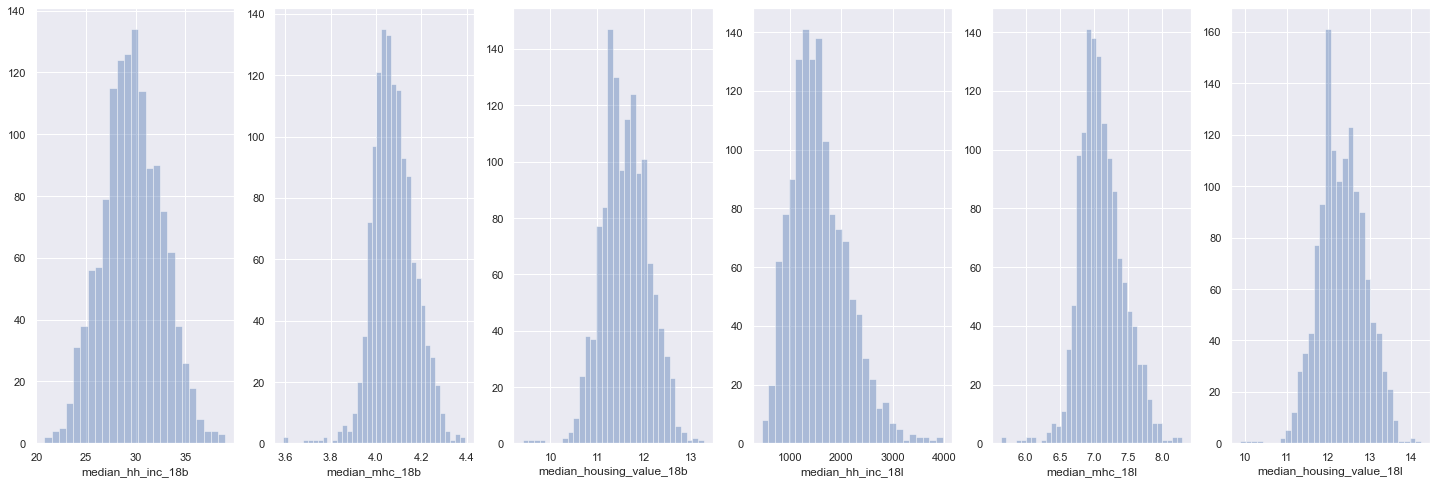

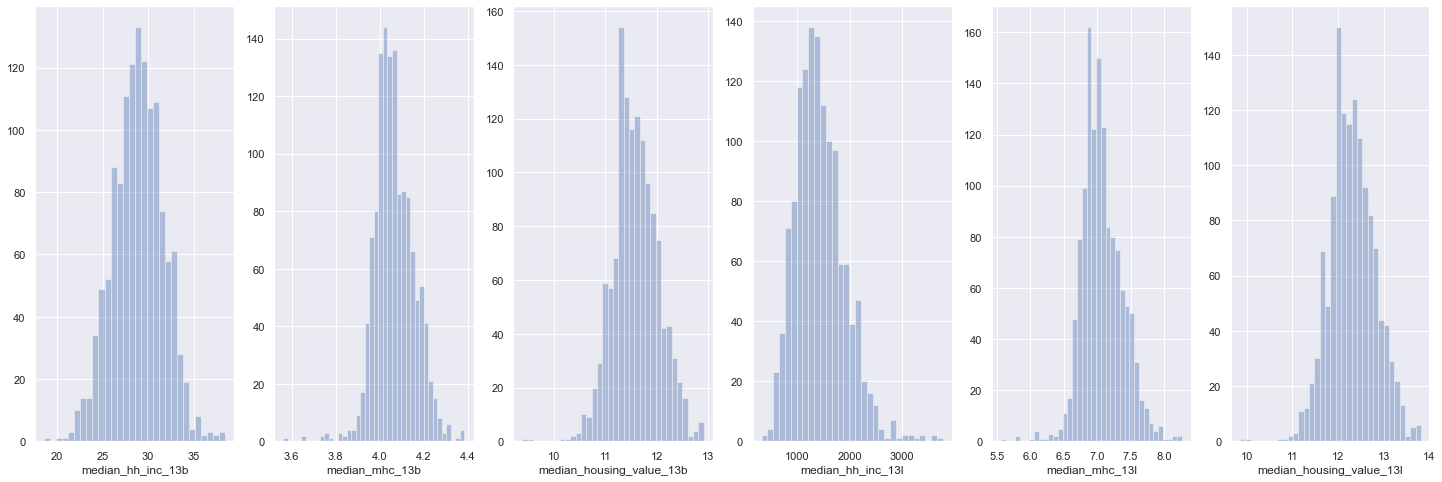

In [29]:
show_distribution(df_transformed_18, df_transformed_18.columns[3:], figsize=(25, 8))
show_distribution(df_transformed_13, df_transformed_13.columns[3:], figsize=(25, 8))

### STEP 3: PCA Analysis
Tasks: Pick a transformation to use ('untransformed', 'Box-Cox', or 'log'), concatenate 2013 and 2018 data into one array, median removal and unit scaling, fit PCA, calculate socioeconomic scores

In [30]:
# Don't forget to set the house price and income scores to the 
# transform/non-transform that you want to use!
# Untransformed explained variance: 0.82489
# Box-Cox explained variance: 0.79890
# Log explained variance (using only log transformation): 0.79791
# Log explained variance (using both power and log transformations): 0.81340
to_use = 'Log' # Choices: ['Untransformed','Box-Cox','Log']

In [31]:
#  Indicators
pwc13 = merged_13['per_white_collar']  #  percent white collar
pwc18 = merged_18['per_white_collar']  #  percent white collar
pcg13 = merged_13['per_grads'] # percent college graduates
pcg18 = merged_18['per_grads'] # percent college graduates

mhi18 = None  #  Household Income
mhi13 = None  #  Household Income
mhc18 = None  #  Monthly Housing Costs
mhc13 = None  #  Monthly Housing Costs
mhv13 = None  #  Housing Value
mhv18 = None  #  Housing Value

if to_use == 'Untransformed':
    mhi18 = df_transformed_18['median_hh_inc_18u']  #  Household Income
    mhi13 = df_transformed_13['median_hh_inc_13u']  #  Household Income
    mhc18 = df_transformed_18['median_mhc_18u']  #  Monthly Housing Costs
    mhc13 = df_transformed_13['median_mhc_13u']  #  Monthly Housing Costs
    mhv13 = df_transformed_18['median_housing_value_18u']  #  Housing Value
    mhv18 = df_transformed_13['median_housing_value_13u']  #  Housing Value
elif to_use == 'Box-Cox':
    mhi18 = df_transformed_18['median_hh_inc_18b']  #  Household Income
    mhi13 = df_transformed_13['median_hh_inc_13b']  #  Household Income
    mhc18 = df_transformed_18['median_mhc_18b']  #  Monthly Housing Costs
    mhc13 = df_transformed_13['median_mhc_13b']  #  Monthly Housing Costs
    mhv13 = df_transformed_18['median_housing_value_18b']  #  Housing Value
    mhv18 = df_transformed_13['median_housing_value_13b']  #  Housing Value
elif to_use == 'Log':
    mhi18 = df_transformed_18['median_hh_inc_18l']  #  Household Income
    mhi13 = df_transformed_13['median_hh_inc_13l']  #  Household Income
    mhc18 = df_transformed_18['median_mhc_18l']  #  Monthly Housing Costs
    mhc13 = df_transformed_13['median_mhc_13l']  #  Monthly Housing Costs
    mhv13 = df_transformed_18['median_housing_value_18l']  #  Housing Value
    mhv18 = df_transformed_13['median_housing_value_13l']  #  Housing Value

In [32]:
res_13 = pd.concat([pwc13, pcg13, mhi13, mhc13, mhv13], axis=1)
res_18 = pd.concat([pwc18, pcg18, mhi18, mhc18, mhv18], axis=1)

SES_inds = np.concatenate((res_13, res_18), axis=0)

print("Any infinite values? " + str(~np.isfinite(SES_inds).any()))
print("Any NaN values? " + str(np.isnan(SES_inds).any()))

Any infinite values? False
Any NaN values? False


In [33]:
#  Median removal and Unit scaling
scaler = preprocessing.RobustScaler()
scaler.fit(SES_inds)
SES_inds = scaler.transform(SES_inds)

print("Data scaled and transformed.")

Data scaled and transformed.


In [34]:
SES_inds

array([[ 0.18568959,  0.14038326, -0.63764462, -0.60282786,  0.23007542],
       [ 0.16006522,  0.0671717 , -0.39915953, -0.21027164, -0.47453201],
       [ 0.2591265 ,  0.12877353, -0.50808242, -0.46849202, -0.4449826 ],
       ...,
       [ 0.69637767,  0.80884334,  1.37726328,  1.26694108,  0.90578047],
       [-0.67971417, -0.29632012, -0.56838359, -0.12904613, -0.46731169],
       [ 0.58702274,  0.21141923, -0.56819537, -0.15429071, -0.30904917]])

In [35]:
pca_full = PCA()                           # Use all Principal Components
pca_full.fit(SES_inds)                                   # Train model on data
SES_full_T = pd.DataFrame(pca_full.transform(SES_inds))  # Transform data using model

print("The amount of explained variance of the SES score using each component is...")
print(pca_full.explained_variance_ratio_)

# Adapted from https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
i = np.identity(SES_inds.shape[1])  # identity matrix

coef = pca_full.transform(i)

loadings = pd.DataFrame(coef, index=['Percent White Collar', 'Percent College Graduate', 'Median Household Income', 'Median Monthly Housing Cost', 'Median Housing Values'])
loadings.to_csv(os.path.join(ses,to_use + '-Loadings-2018.csv.gz'), compression='gzip', index=True)

The amount of explained variance of the SES score using each component is...
[0.80796355 0.09742579 0.06057666 0.02500561 0.00902839]


In [36]:
loadings

,0,1,2,3,4
Percent White Collar,0.186524,0.444836,0.413297,-0.036271,0.661478
Percent College Graduate,0.202589,0.343038,0.311860,0.025935,-0.743947
Median Household Income,0.298102,-0.472647,-0.100971,0.706740,0.087684
Median Monthly Housing Cost,0.291883,-0.519462,-0.041819,-0.704023,0.024293
Median Housing Values,0.240421,0.440277,-0.856323,-0.061729,0.041404


In [37]:
SES_full_T

,0,1,2,3,4
0,-0.586217,0.856613,-0.110302,-0.062548,-0.019845
1,-0.624212,0.194266,0.406520,-0.129790,0.021278
2,-0.729556,0.459146,0.450203,-0.030793,0.028770
3,-0.737201,0.279327,0.183560,0.141467,0.039256
4,-0.090790,0.893348,0.466238,0.078527,-0.310083
...,...,...,...,...,...
2625,-2.017971,0.018065,-0.214798,0.170584,0.004989
2626,-0.002486,0.536709,0.106262,-0.346530,-0.090088
2627,2.107030,-0.347205,-0.130527,0.066979,-0.006930
2628,-1.137601,-0.255374,-0.140485,-0.300475,-0.258989


In [38]:
#  Fitting PCA Model to derive SES score
pca = PCA(n_components=1)             # Only need 1st Principal Component
pca.fit(SES_inds)                                   #  Train model on data
SES_inds_T = pd.DataFrame(pca.transform(SES_inds))  #  Transform data using model

print("The amount of explained variance of the SES score is: {0:6.5f}".format(pca.explained_variance_ratio_[0]))

The amount of explained variance of the SES score is: 0.80796


In [39]:
SES_inds_T

,0
0,-0.586217
1,-0.624212
2,-0.729556
3,-0.737201
4,-0.090790
...,...
2625,-2.017971
2626,-0.002486
2627,2.107030
2628,-1.137601


In [40]:
#  Split transformed data into 2001 and 2011 datasets
#  Note the way we do this to deal with missing data (if any)
scores_13 = SES_inds_T.loc[:len(res_13) - 1, 0]
scores_18 = SES_inds_T.loc[len(res_13):, 0]

# Create dfs from the two sets of scores
res_13 = res_13.assign(scores=pd.Series(scores_13).values)
res_18 = res_18.assign(scores=pd.Series(scores_18).values)

#res.columns = ['LSOANM','PRICE-01','QUALS-01','OCC-01','INCOME-01','PRICE-11',
#               'QUALS-11','OCC-11','INCOME-11','SES_01','SES_11']

# Join them together so we've got a single df for 2001 and 2011
res = res_13.merge(res_18, how='outer', suffixes=('_13','_18'), left_index=True, right_index=True)

# Rename columns for consistency with Jordan's code
res.rename(columns={'scores_13':'SES_13', 'scores_18':'SES_18'}, inplace=True)

# Sanity check
res.head(3)

,per_white_collar_13,per_grads_13,median_hh_inc_13l,median_mhc_13l,median_housing_value_18l,SES_13,per_white_collar_18,per_grads_18,median_hh_inc_18l,median_mhc_18l,median_housing_value_13l,SES_18
geo11,,,,,,,,,,,,
17031010100,0.389247,0.416900,1011.943609,6.807935,12.458387,-0.586217,0.476343,0.493519,1129.990400,6.866933,12.232228,-0.360387
17031010201,0.381977,0.390406,1167.813010,6.965080,11.960811,-0.624212,0.373981,0.371417,1160.798945,6.972606,12.181268,-0.514593
17031010202,0.410084,0.412698,1096.623039,6.861711,11.981678,-0.729556,0.294420,0.399502,1137.612965,6.888572,12.356646,-0.603481


In [41]:
#  Compute rank of LSOA in 2001 (so low rank = 'low status')
res['RANK_13'] = res.SES_13.rank(ascending=False)

#  Compute rank of LSOA in 2011 (so low rank = 'low status')
res['RANK_18'] = res.SES_18.rank(ascending=False)

#  Compute amount by which LSOA has ascended (so +ve = status improvement; -ve = status decline)
res.loc[:,'SES_ASC'] = res.loc[:,'SES_18'] - res.loc[:,'SES_13']

In [42]:
#  Calculate LSOA percentile score in 01
res.loc[:,'SES_PR_13'] = res.RANK_13.rank(ascending=False, pct=True) * 100

#  Calculate LSOA percentile score in 11
res.loc[:,'SES_PR_18'] = res.RANK_18.rank(ascending=False, pct=True) * 100

#  Calculate percentile change (so +ve = 'moved up' in the world; -ve = 'moved down')
res.loc[:,'SES_PR_ASC'] = res.loc[:,'SES_PR_18'] - res.loc[:,'SES_PR_13']

inp = res.loc[:,[x for x in res.columns if 'SES' not in x and 'RANK' not in x]]

In [43]:
res.describe()

,per_white_collar_13,per_grads_13,median_hh_inc_13l,median_mhc_13l,median_housing_value_18l,SES_13,per_white_collar_18,per_grads_18,median_hh_inc_18l,median_mhc_18l,median_housing_value_13l,SES_18,RANK_13,RANK_18,SES_ASC,SES_PR_13,SES_PR_18,SES_PR_ASC
count,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1.315000e+03
mean,0.354246,0.391090,1430.381356,7.068050,12.325085,-0.106319,0.376691,0.426515,1568.507865,7.107758,12.306047,0.106319,658.000000,658.000000,0.212638,50.038023,50.038023,-4.322693e-17
std,0.179858,0.230850,472.350533,0.307400,0.559238,1.409999,0.186103,0.233444,548.320856,0.321965,0.497704,1.501038,379.752112,379.752112,0.334447,28.878488,28.878488,6.956013e+00
min,0.019144,0.023451,320.024819,5.556828,9.873028,-3.817386,0.000000,0.027933,457.544205,5.634790,9.852194,-3.460321,1.000000,1.000000,-1.005110,0.076046,0.076046,-3.353612e+01
25%,0.212901,0.198670,1097.297338,6.869534,11.948272,-1.162263,0.225750,0.230447,1175.904705,6.894163,11.978543,-1.041508,329.500000,329.500000,0.000439,25.057034,25.057034,-3.574144e+00
50%,0.327234,0.342000,1379.735737,7.028201,12.315824,-0.365753,0.342767,0.386108,1490.729227,7.072422,12.279323,-0.152649,658.000000,658.000000,0.194543,50.038023,50.038023,-1.520913e-01
75%,0.488052,0.547907,1708.070162,7.260874,12.713342,0.822323,0.517020,0.597491,1899.524619,7.303507,12.629050,1.103490,986.500000,986.500000,0.409927,75.019011,75.019011,3.422053e+00
max,0.821942,0.960477,3774.295952,8.267192,14.239863,5.169082,1.000000,0.974755,3968.513213,8.294300,13.815512,5.351880,1315.000000,1315.000000,2.338359,100.000000,100.000000,5.193916e+01


In [44]:
export_file = res[[x for x in res.columns if 'SES' in x or 'RANK' in x]]
export_file.to_csv(os.path.join(ses, to_use + '_socioeconomic_scores_2013_2018.csv'), index=True)

In [45]:
export_file

,SES_13,SES_18,RANK_13,RANK_18,SES_ASC,SES_PR_13,SES_PR_18,SES_PR_ASC
geo11,,,,,,,,
17031010100,-0.586217,-0.360387,740.0,731.0,0.225830,43.802281,44.486692,0.684411
17031010201,-0.624212,-0.514593,758.0,786.0,0.109618,42.433460,40.304183,-2.129278
17031010202,-0.729556,-0.603481,801.0,825.0,0.126074,39.163498,37.338403,-1.825095
17031010300,-0.737201,-0.426184,807.0,758.0,0.311017,38.707224,42.433460,3.726236
17031010400,-0.090790,0.103754,568.0,574.0,0.194543,56.882129,56.425856,-0.456274
...,...,...,...,...,...,...,...,...
17031843500,-2.009112,-2.017971,1259.0,1262.0,-0.008859,4.334601,4.106464,-0.228137
17031843600,-0.972480,-0.002486,916.0,615.0,0.969995,30.418251,53.307985,22.889734
17031843700,1.359906,2.107030,209.0,160.0,0.747124,84.182510,87.908745,3.726236


### Mapping the Results
Using community areas to map the results for verification

In [46]:
res_gdf = gpd.GeoDataFrame(pd.merge(res, il_shape_18, how='inner', left_index=True, right_index=True), crs=il_shape_18.crs)
print(res_gdf.shape)
res_gdf.head(3)

(1315, 30)


,per_white_collar_13,per_grads_13,median_hh_inc_13l,median_mhc_13l,median_housing_value_18l,SES_13,per_white_collar_18,per_grads_18,median_hh_inc_18l,median_mhc_18l,...,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
geo11,,,,,,,,,,,,,,,,,,,,,
17031010100,0.389247,0.416900,1011.943609,6.807935,12.458387,-0.586217,0.476343,0.493519,1129.990400,6.866933,...,010100,101,Census Tract 101,G5020,S,379751,0,+42.0212564,-087.6698316,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
17031010201,0.381977,0.390406,1167.813010,6.965080,11.960811,-0.624212,0.373981,0.371417,1160.798945,6.972606,...,010201,102.01,Census Tract 102.01,G5020,S,504465,0,+42.0160077,-087.6801484,"POLYGON ((-87.68465 42.01948, -87.68432 42.019..."
17031010202,0.410084,0.412698,1096.623039,6.861711,11.981678,-0.729556,0.294420,0.399502,1137.612965,6.888572,...,010202,102.02,Census Tract 102.02,G5020,S,351758,0,+42.0160507,-087.6733216,"POLYGON ((-87.67683 42.01941, -87.67674 42.019..."


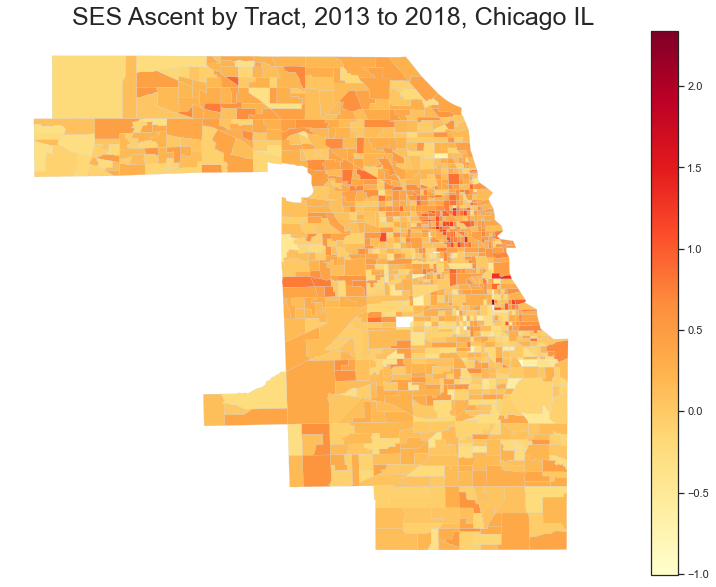

In [47]:
sns.set(style='white')
var = 'SES_ASC'
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
ax.set_title('SES Ascent by Tract, 2013 to 2018, Chicago IL', fontdict={'fontsize': '25', 'fontweight': '3'}, loc='right')
res_gdf.plot(column=var, cmap='YlOrRd', linewidth=0.2, ax=ax, edgecolor='0.8', legend=True)
plt.show()

In [48]:
by_commarea = pd.merge(res_gdf, commarea, how='inner', on='commarea')

KeyError: 'commarea'

In [ ]:
commarea.commarea.nunique()

In [ ]:
by_commarea

In [ ]:
by_commarea_gdf = gpd.GeoDataFrame(pd.merge(by_commarea.groupby(['commarea']).sum(), commarea, how='inner', on='commarea'), crs=commarea.crs)

In [ ]:
by_commarea_gdf["SES_ASC"].min()

In [ ]:
sns.set(style='white')
var = 'SES_ASC'
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
ax.set_title('SES Ascent by Community Area, 2013 to 2018, Chicago IL', fontdict={'fontsize': '25', 'fontweight': '3'}, loc='right')
by_commarea_gdf.plot(column=var, cmap='Greens', linewidth=0.2, ax=ax, edgecolor='0.6', legend=True)
plt.show()